# Desarrollo del Proyecto

## Objetivo

El objetivo principal de este proyecto es aplicar el algoritmo de Agglomerative Hierarchical Clustering para identificar los municipios en los que se debe enfocar un mayor esfuerzo y recursos con el fin de combatir los homicidios contra un segmento de la población especialmente vulnerable, como lo son los niños, niñas y adolescentes. El enfoque en este grupo demográfico se debe a la importancia de proteger a los más jóvenes de la sociedad y garantizar su seguridad. El proyecto busca agrupar municipios con perfiles similares en términos de homicidios contra este grupo, lo que permitirá una asignación más eficiente de recursos y esfuerzos preventivos.

## Desarrollo

El desarrollo de este proyecto se llevará a cabo en las siguientes etapas:

### Análisis Descriptivo de la Información

#### Analisis Exploratorio de Datos y Preprocesamiento de la Información

En esta fase inicial, se realizará un análisis detallado de los datos disponibles. Se verificarán las características de la información, se identificarán posibles datos atípicos y se llevará a cabo la limpieza y preparación de los datos para su posterior análisis. Este paso es fundamental para garantizar la calidad y confiabilidad de los resultados del clustering.

### Clustering con Agglomerative Hierarchical Clustering

En esta etapa central del proyecto, se aplicará el algoritmo de Agglomerative Hierarchical Clustering. Este algoritmo es especialmente adecuado para el caso, ya que puede manejar datos mixtos, incluyendo variables categóricas y numéricas. Se exploraran diferentes enfoques y configuraciones para identificar los grupos de municipios que presentan patrones similares en términos de homicidios contra niños, niñas y adolescentes. Se dara uso técnicas de visualización, como dendrogramas, para comprender la estructura de los grupos.

### Resultados y Evaluación

Una vez completado el proceso de clustering, se evaluaran los resultados obtenidos. Se analizara la composición de los grupos identificados y verificando si existen diferencias significativas en los niveles de homicidios entre los grupos. También se examinara la coherencia interna de los grupos y su capacidad para identificar municipios con necesidades similares en términos de prevención de homicidios.

### Conclusiones y Recomendaciones

Finalmente, con base en los resultados obtenidos, se determinaran conclusiones importantes y daran recomendaciones para la toma de decisiones identificando los municipios que requieren una atención prioritaria en la lucha contra los homicidios dirigidos a niños, niñas y adolescentes.

In [1]:
## Se cargan las líbrerias que a las que se le dara uso para el desarrollo de este proyecto
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from gower import gower_matrix
from kneed import KneeLocator

### Analisis Descriptivo de la Información

Se procede a cargar la información y realizar un analissi de los datos de los que se dispone en la base de datos obtenidas del CEDE.

In [4]:
## Se carga la base original
df = pd.read_stata(r'..\data\Homicidios_2003-Ag2017.dta')
df.head()

,Departamento,Municipio,coddepto,codmpio,fecha,genero,edad,grupo_edad,n_homicidios
0,Antioquia,Medellín,5,5001.0,2003-01-01,MASCULINO,27.0,ADULTOS,1.0
1,Antioquia,Medellín,5,5001.0,2003-01-01,FEMENINO,19.0,ADULTOS,1.0
2,Antioquia,Medellín,5,5001.0,2003-01-01,MASCULINO,18.0,ADULTOS,2.0
3,Antioquia,Medellín,5,5001.0,2003-01-01,MASCULINO,43.0,ADULTOS,1.0
4,Antioquia,Medellín,5,5001.0,2003-01-01,MASCULINO,28.0,ADULTOS,1.0


In [3]:
## Se ven las caracteristicas generales de las variables númericas
df.describe()

,coddepto,codmpio,edad,n_homicidios
count,221538.000000,221538.000000,219344.00000,221538.000000
mean,40.573378,40821.849430,32.23739,1.027232
std,29.050849,29066.391727,12.57412,0.208083
min,5.000000,5001.000000,0.00000,1.000000
25%,11.000000,11001.000000,23.00000,1.000000
50%,44.000000,44001.000000,30.00000,1.000000
75%,73.000000,73410.250000,39.00000,1.000000
max,99.000000,99773.000000,99.00000,25.000000


In [4]:
# Tamaño de la base
df.shape

(221538, 9)

Como se puede ver a primera vista se cuenta con una base de datos bastante completa con nueve variables y 221.538 filas. Sin embargo, la base de datos contiene informacón más alla de los adolescentes y menores de edad como se puede observar a continuación por lo cual es necesario depurarla.

In [5]:
conteo_valores_grupo_edad = df['grupo_edad'].value_counts()
conteo_valores_grupo_edad

ADULTOS         207757
ADOLESCENTES     11993
MENORES           1788
Name: grupo_edad, dtype: int64

In [6]:
df_vulnerable = df[(df['grupo_edad'] == 'ADOLESCENTES') | (df['grupo_edad'] == 'MENORES')]

Se crea por lo tanto un nuevo df_vulnerable que contiene únicamente la población de interés. Hecho ya esta depuración se procede a revisar las caracteristicas que se tienen:

In [7]:
## Se ven las caracteristicas generales de las variables númericas
df_vulnerable.describe()

,coddepto,codmpio,edad,n_homicidios
count,13781.000000,13781.000000,13781.000000,13781.000000
mean,42.205138,42421.057833,14.771062,1.025615
std,29.855901,29856.101980,3.669558,0.165604
min,5.000000,5001.000000,0.000000,1.000000
25%,11.000000,11001.000000,15.000000,1.000000
50%,47.000000,47001.000000,16.000000,1.000000
75%,76.000000,76001.000000,17.000000,1.000000
max,99.000000,99773.000000,17.000000,3.000000


In [8]:
## Se verifica si existen valores nulos
valores_nulos = df_vulnerable.isna().sum()
print(valores_nulos)

Departamento    0
Municipio       0
coddepto        0
codmpio         0
fecha           0
genero          0
edad            0
grupo_edad      0
n_homicidios    0
dtype: int64


Se puede observar que en esta nueva base de datos se tiene un promedio de edad de 14.77 (comparado con la original en la que el promedio era 32.23)

In [9]:
genero = df_vulnerable['genero'].value_counts()
print(genero)

MASCULINO     11586
FEMENINO       2191
NO REPORTA        4
Name: genero, dtype: int64


In [10]:
municipio = df_vulnerable['Municipio'].value_counts()
print(municipio)

Cali            2397
Bogotá, D.C.    1254
Medellín        1012
Barranquilla     254
Palmira          236
                ... 
Pijao              1
Tutazá             1
Salento            1
Tuta               1
Sesquilé           1
Name: Municipio, Length: 775, dtype: int64


In [11]:
departamento = df_vulnerable['Departamento'].value_counts()
print(departamento)

Valle del Cauca               3661
Antioquia                     2305
Bogotá, D.C.                  1254
Cauca                          520
Nariño                         493
Santander                      460
Risaralda                      451
Cundinamarca                   409
Caldas                         390
Atlántico                      385
Norte de Santander             371
Huila                          313
Bolívar                        312
Tolima                         284
Meta                           274
Quindio                        246
Cesar                          195
Magdalena                      185
Caquetá                        170
Chocó                          168
Córdoba                        166
Putumayo                       152
La Guajira                     144
Arauca                         144
Boyacá                         112
Sucre                           76
Casanare                        67
Guaviare                        33
Archipiélago de San 

Realizando una revisión rápida se puede observar que el número de homicidios parece variar mucho dependiendo de donde este ocurriendo y del genero afectado.

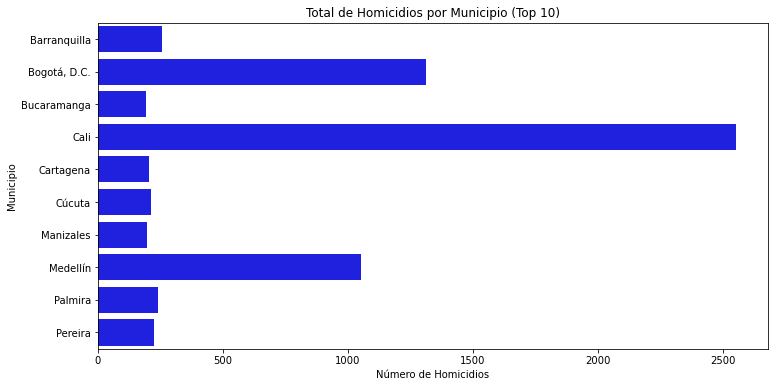

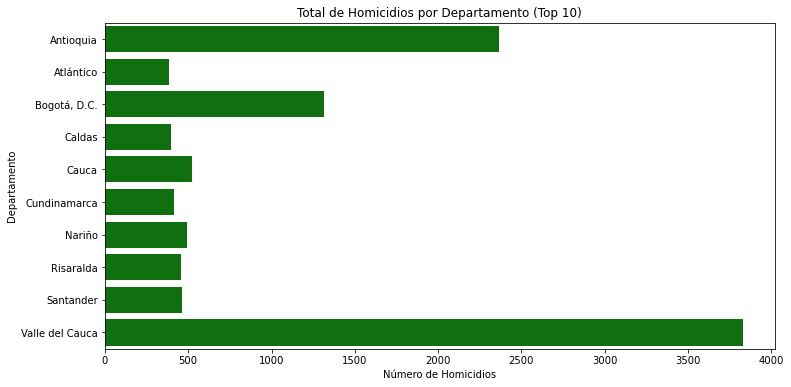

In [12]:
## Se grafica para apreciar más la diferencia

# Se filtran los diez municipios y departamentos principales
top_municipios = df_vulnerable['Municipio'].value_counts().head(10).index.tolist()
top_departamentos = df_vulnerable['Departamento'].value_counts().head(10).index.tolist()
top_df_m = df_vulnerable[df_vulnerable['Municipio'].isin(top_municipios)]
top_df_d = df_vulnerable[df_vulnerable['Departamento'].isin(top_departamentos)]

# Se proceden a crear dos gráficos
total_homicidios_municipio = top_df_m.groupby('Municipio')['n_homicidios'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='n_homicidios', y='Municipio', data=total_homicidios_municipio, color='blue')
plt.title('Total de Homicidios por Municipio (Top 10)')
plt.xlabel('Número de Homicidios')
plt.ylabel('Municipio')
plt.show()

total_homicidios_departamento = top_df_d.groupby('Departamento')['n_homicidios'].sum().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='n_homicidios', y='Departamento', data=total_homicidios_departamento, color='green')
plt.title('Total de Homicidios por Departamento (Top 10)')
plt.xlabel('Número de Homicidios')
plt.ylabel('Departamento')
plt.show()

Como se puede observar con estos resultados historicamente el Valle del Cauca y Cali parecen ser los el departamento y municipio respectivamente donde más se han presentado homcidios 

### Clustering con Agglomerative Hierarchical Clustering

Se procede a desarrollar el Clustering

In [13]:
df_vulnerable.head(1)

,Departamento,Municipio,coddepto,codmpio,fecha,genero,edad,grupo_edad,n_homicidios
10,Antioquia,Medellín,5,5001.0,2003-01-01,MASCULINO,16.0,ADOLESCENTES,1.0


In [14]:
## Se estandariza la información a la que se dara uso

scaler = StandardScaler()
Municipio_num, Municipio_unicos = pd.factorize(df_vulnerable['Municipio'])
df_vulnerable['Municipio_factor'] = Municipio_num
Dep_num, Dep_unicos = pd.factorize(df_vulnerable['Departamento'])
df_vulnerable['Dep_factor'] = Dep_num
dic_Mun = dict(zip(Municipio_num, Municipio_unicos))
dic_Dep = dict(zip(Dep_num, Dep_unicos))
scaled_data = scaler.fit_transform(df_vulnerable[['n_homicidios', 'Dep_factor', 'Municipio_factor']])
X = scaled_data



C:\Users\Felipe\AppData\Local\Temp\ipykernel_22228\823030861.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vulnerable['Municipio_factor'] = Municipio_num
C:\Users\Felipe\AppData\Local\Temp\ipykernel_22228\823030861.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vulnerable['Dep_factor'] = Dep_num


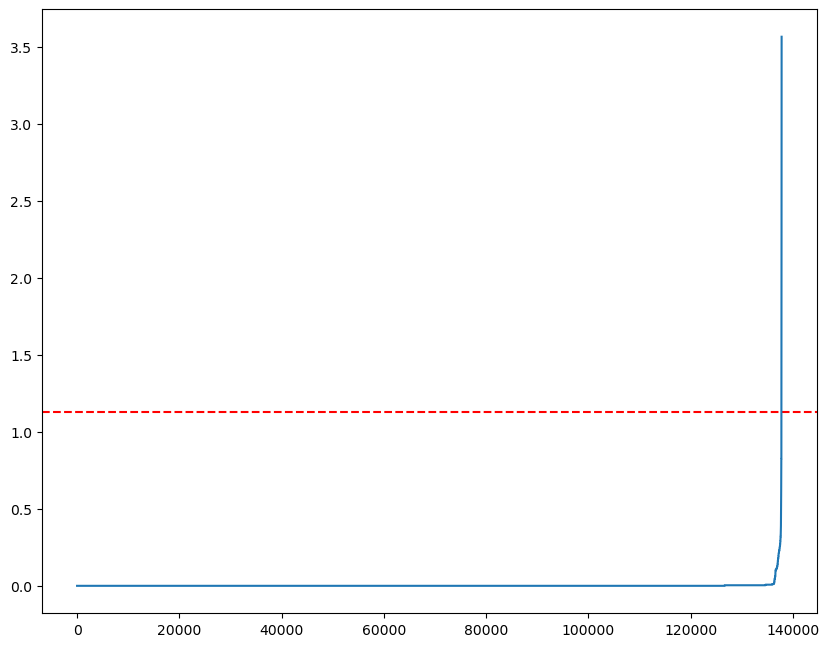

In [15]:
neigh = NearestNeighbors(n_neighbors = 10)
nbrs = neigh.fit(X)
distancias, indices = nbrs.kneighbors(X)
distancias = np.sort(distancias.flatten())
fig=plt.figure(figsize=(10,8), dpi= 100, facecolor='w', edgecolor='k')
plt.axhline(y = 1.13, color = 'r', linestyle = '--')
plt.plot(distancias)

In [16]:
i = np.arange(len(distancias))
knee = KneeLocator(i, distancias, S=1, curve='convex', direction='increasing', interp_method='polynomial')

print(distancias[knee.knee])

0.0


In [17]:
gower_dist_matrix = gower_matrix(X)

In [ ]:
# Calcula el enlace utilizando la matriz de distancias de Gower y el método de enlace deseado
Z = linkage(gower_dist_matrix, method='ward')  # Puedes elegir otro método si lo prefieres

# Crea un dendrograma para visualizar el clustering jerárquico
plt.figure(figsize=(10, 6))
dendrogram(Z, labels=labels)  # Labels son las etiquetas de tus observaciones si las tienes
plt.title('Dendrograma de Clustering Jerárquico')
plt.xlabel('Índices de Datos')
plt.ylabel('Distancia')
plt.show()